In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
from datetime import datetime, timedelta
from airflow import DAG
from airflow.operators.python_operator import PythonOperator

/var/folders/02/cjc3s3b54s3d6prfzqh3_cbw0000gn/T/ipykernel_23509/1319295993.py:15 DeprecationWarning: The `airflow.operators.python_operator.PythonOperator` class is deprecated. Please use `'airflow.operators.python.PythonOperator'`.

# A) Load and preprocess Data

In [2]:
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', delimiter=';')

In [3]:
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [4]:
X = data.drop("quality", axis=1)
y = data["quality"]

In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# B) Train Model and MLFlow

In [7]:
import mlflow
import mlflow.sklearn

In [8]:
experiment_name = "Wine_Quality_Classification"
mlflow.set_experiment(experiment_name)

2023/05/05 21:16:34 INFO mlflow.tracking.fluent: Experiment with name 'Wine_Quality_Classification' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///Users/musadac/Desktop/mlruns/388648613170966978', creation_time=1683303394518, experiment_id='388648613170966978', last_update_time=1683303394518, lifecycle_stage='active', name='Wine_Quality_Classification', tags={}>

/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


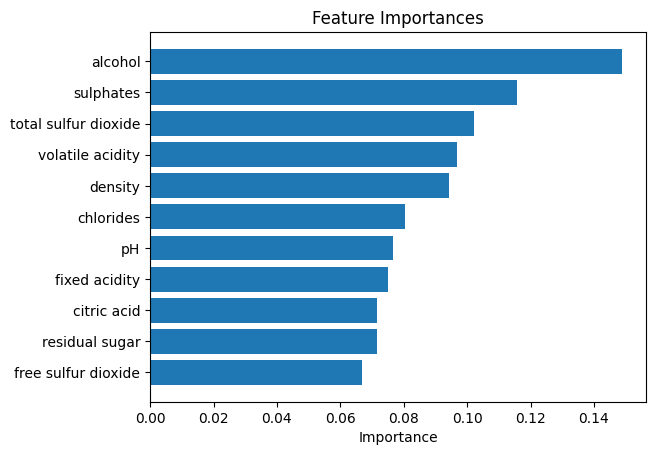

In [13]:
with mlflow.start_run():
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    mlflow.sklearn.log_model(model, "random_forest_classifier")
    for label, metrics in report.items():
        if isinstance(metrics, dict):
            for metric_name, metric_value in metrics.items():
                mlflow.log_metric(f"{label}_{metric_name}", metric_value)
        else:
            mlflow.log_metric(label, metrics)
    
    feature_importances = model.feature_importances_
    sorted_idx = np.argsort(feature_importances)
    pos = np.arange(sorted_idx.shape[0]) + 0.5
    plt.barh(pos, feature_importances[sorted_idx], align='center')
    plt.yticks(pos, X.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.title('Feature Importances')
    plt.savefig('feature_importances.png')
    
    mlflow.log_artifact('feature_importances.png')

In [ ]:
! mlflow ui --host 0.0.0.0:3003

[2023-05-05 21:52:14 +0500] [23879] [INFO] Starting gunicorn 20.1.0
[2023-05-05 21:52:14 +0500] [23879] [INFO] Listening at: http://0.0.0.0:3003 (23879)
[2023-05-05 21:52:14 +0500] [23879] [INFO] Using worker: sync
[2023-05-05 21:52:15 +0500] [23880] [INFO] Booting worker with pid: 23880
[2023-05-05 21:52:15 +0500] [23881] [INFO] Booting worker with pid: 23881
[2023-05-05 21:52:15 +0500] [23882] [INFO] Booting worker with pid: 23882
[2023-05-05 21:52:15 +0500] [23883] [INFO] Booting worker with pid: 23883


In [21]:
def preprocess_data():    
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
    data = pd.read_csv(url, delimiter=";")
    X = data.drop("quality", axis=1)
    y = data["quality"]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test

In [22]:
def train_model(X_train, y_train):
    experiment_name = "Wine_Quality_Classification"
    mlflow.set_experiment(experiment_name)
    with mlflow.start_run():
        model = RandomForestClassifier(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        report = classification_report(y_test, y_pred, output_dict=True)
        mlflow.sklearn.log_model(model, "random_forest_classifier")
        for label, metrics in report.items():
            if isinstance(metrics, dict):
                for metric_name, metric_value in metrics.items():
                    mlflow.log_metric(f"{label}_{metric_name}", metric_value)
            else:
                mlflow.log_metric(label, metrics)

        feature_importances = model.feature_importances_
        sorted_idx = np.argsort(feature_importances)
        pos = np.arange(sorted_idx.shape[0]) + 0.5
        plt.barh(pos, feature_importances[sorted_idx], align='center')
        plt.yticks(pos, X.columns[sorted_idx])
        plt.xlabel('Importance')
        plt.title('Feature Importances')
        plt.savefig('feature_importances.png')

        mlflow.log_artifact('feature_importances.png')
    
    return model

In [23]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    return report

In [24]:
def deploy_model(model):
    !git push
    pass

In [25]:
default_args = {
    "owner": "airflow",
    "depends_on_past": False,
    "start_date": datetime(2023, 5, 5),
    "email_on_failure": False,
    "email_on_retry": False,
    "retries": 1,
    "retry_delay": timedelta(minutes=5),
}

In [26]:
dag = DAG(
    "wine_quality_pipeline",
    default_args=default_args,
    description="A pipeline to preprocess, train, evaluate, and deploy a wine quality prediction model",
    schedule_interval=timedelta(days=1),
    catchup=False,
)

/var/folders/02/cjc3s3b54s3d6prfzqh3_cbw0000gn/T/ipykernel_23509/4187660615.py:1 RemovedInAirflow3Warning: Param `schedule_interval` is deprecated and will be removed in a future release. Please use `schedule` instead.

In [33]:
preprocess_task = PythonOperator(
    task_id="preprocess_data2",
    python_callable=preprocess_data,
    dag=dag,
)

train_task = PythonOperator(
    task_id="train_model2",
    python_callable=train_model,
    dag=dag,
)

evaluate_task = PythonOperator(
    task_id="evaluate_model2",
    python_callable=evaluate_model,
    dag=dag,
)

deploy_task = PythonOperator(
    task_id="deploy_model2",
    python_callable=deploy_model,
    dag=dag,
)

In [34]:
preprocess_task >> train_task
train_task >> evaluate_task
evaluate_task >> deploy_task

<Task(PythonOperator): deploy_model2>